experiment_id: 879101503137809789, experiment.name: Noise Forecasting


,run_id,run_name,mae,rmse,mape,smape,mase,min_samples_split,max_depth,min_samples_leaf,n_estimators,order_q,seasonal_D,seasonal_s,order_d,seasonal_Q,order_p,seasonal_P,rank_mae,rank_rmse,rank_mape,rank_smape,rank_mase,rank_sum
10,b8d7ce28d1a14f3ab815f474b882a56a,random_forest_train,NaN,NaN,NaN,NaN,NaN,2,6,4,100,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,0.0
11,9bf5d319a3fc4e15967d412c9e76774f,random_forest_train,NaN,NaN,NaN,NaN,NaN,2,6,4,100,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,0.0
0,4840adfef7e34e7d803248ce8c0e13a8,random_forest_train,NaN,1.705918e-01,NaN,NaN,NaN,5,19,2,250,None,None,None,None,None,None,None,NaN,1.0,NaN,NaN,NaN,1.0
1,ac0ad4d5952b4c62be36edd009f61baf,random_forest_train,NaN,2.151422e-01,NaN,NaN,NaN,5,19,2,250,None,None,None,None,None,None,None,NaN,2.0,NaN,NaN,NaN,2.0
2,8db56359b3024d489e481bee011aa614,random_forest_train,NaN,2.151422e-01,NaN,NaN,NaN,5,19,2,250,None,None,None,None,None,None,None,NaN,2.0,NaN,NaN,NaN,2.0
3,f4dcefaf16a843638010d084713c912d,random_forest_train,NaN,2.151422e-01,NaN,NaN,NaN,5,19,2,250,None,None,None,None,None,None,None,NaN,2.0,NaN,NaN,NaN,2.0
4,e751ed60a6674bcab74eee2ece64439a,random_forest_train,NaN,2.821036e-01,NaN,NaN,NaN,6,30,3,350,None,None,None,None,None,None,None,NaN,5.0,NaN,NaN,NaN,5.0
7,6cb45efba60c48b288c25bb6d427d1c2,random_forest_train,NaN,1.123015e+00,NaN,NaN,NaN,2,6,4,100,None,None,None,None,None,None,None,NaN,8.0,NaN,NaN,NaN,8.0
8,5d5ca04b2c52496ea08271cab079dd8e,random_forest_train,NaN,1.123015e+00,NaN,NaN,NaN,2,6,4,100,None,None,None,None,None,None,None,NaN,8.0,NaN,NaN,NaN,8.0
5,72d53644c62849e2b1fc8caf89eb1ad5,random_forest_train,0.707277,1.118017e+00,1.028512,1.029295,0.482241,2,6,4,100,None,None,None,None,None,None,None,1.0,6.0,1.0,1.0,1.0,10.0


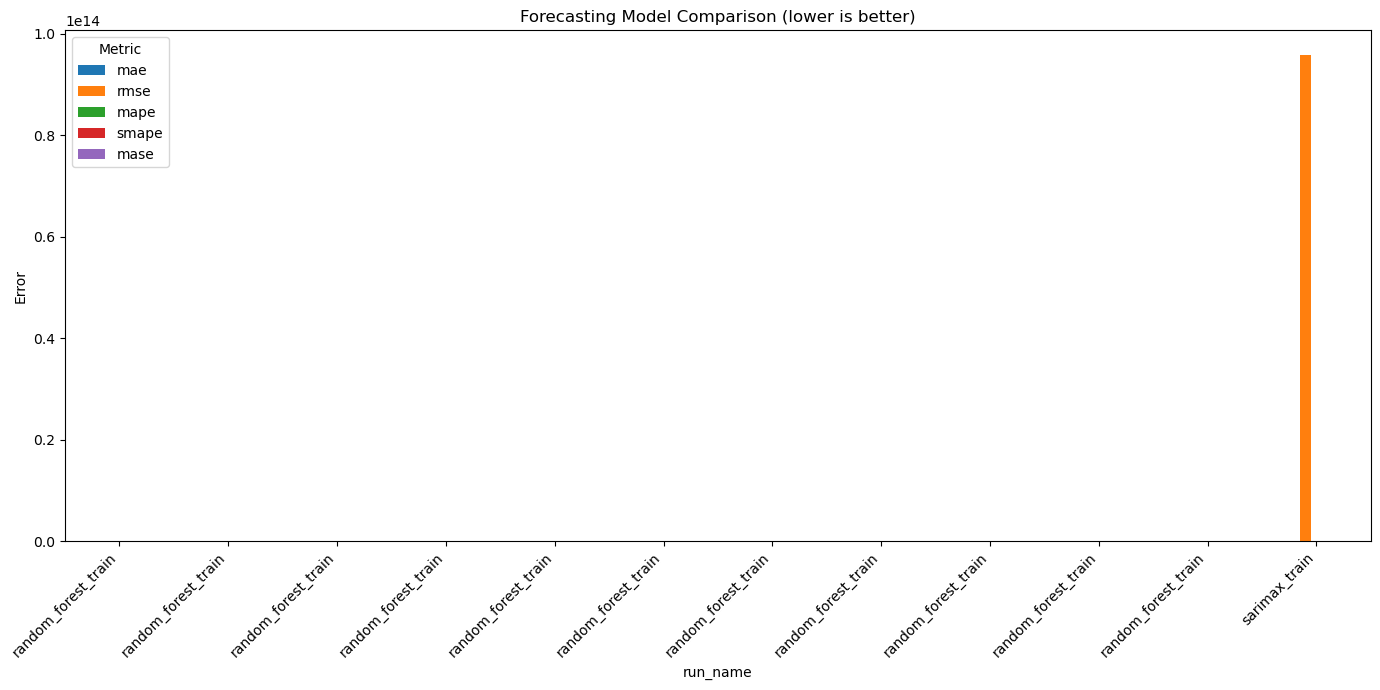

✅ Comparison saved to model_comparison_results.csv


In [1]:
# notebooks/compare_models.ipynb

import mlflow
import mlflow.tracking
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Load MLflow runs ----------
EXPERIMENT_NAME = "Noise Forecasting"


# Force MLflow to look at the root-level mlruns folder
tracking_uri = mlflow.set_tracking_uri("file://" + os.path.abspath("../mlruns"))

client = mlflow.tracking.MlflowClient(tracking_uri=tracking_uri)
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id
print(f"experiment_id: {experiment_id}, experiment.name: {experiment.name}")

# Fetch all runs
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.rmse ASC"],  # sort best first
    output_format="pandas"
)

# --- Select metrics and params ---
metrics = ["mae", "rmse", "mape", "smape", "mase"]
params_cols = [c for c in runs.columns if c.startswith("params.")]
metrics_cols = [f"metrics.{m}" for m in metrics]

# Build comparison DataFrame
cols_to_keep = ["run_id", "tags.mlflow.runName"] + metrics_cols + params_cols
df_compare = runs[cols_to_keep].copy()
df_compare = df_compare.rename(columns={
    "tags.mlflow.runName": "run_name",
    **{c: c.replace("metrics.", "").replace("params.", "") for c in metrics_cols + params_cols}
})

# --- Ranking ---
for m in metrics:
    df_compare[f"rank_{m}"] = df_compare[m].rank(method="min", ascending=True)
df_compare["rank_sum"] = df_compare[[f"rank_{m}" for m in metrics]].sum(axis=1)
df_compare = df_compare.sort_values("rank_sum")

# --- Display table ---
pd.set_option("display.max_columns", None)
display(df_compare.head(20))


# ---------- Plot comparison ----------
plot_df = df_compare[["run_name"] + metrics].set_index("run_name")

ax = plot_df.plot(
    kind="bar",
    figsize=(14, 7),
    title="Forecasting Model Comparison (lower is better)"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Error")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# ---------- Export results ----------
# df_compare.to_csv("model_comparison_results.csv", index=False)
print("✅ Comparison saved to model_comparison_results.csv")